
# ARIMA and Seasonal ARIMA


## Autoregressive Integrated Moving Averages

The general process for ARIMA models is the following:
* Visualize the Time Series Data
* Make the time series data stationary
* Plot the Correlation and AutoCorrelation Charts
* Construct the ARIMA Model or Seasonal ARIMA based on the data
* Use the model to make predictions

Let's go through these steps!

In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df=pd.read_csv('perrin-freres-monthly-champagne-.csv')

In [3]:
df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [5]:
## Cleaning up the data
df.columns=["Month","Sales"]
df.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [6]:
## Drop last 2 rows
df.drop(106,axis=0,inplace=True)

In [7]:
df.tail()

,Month,Sales
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN


In [8]:
df.drop(105,axis=0,inplace=True)

In [9]:
df.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [10]:
# Convert Month into Datetime
df['Month']=pd.to_datetime(df['Month'])

In [11]:
df.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [12]:
df.set_index('Month',inplace=True)

In [13]:
df.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [14]:
df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


## Step 2: Visualize the Data

<AxesSubplot:xlabel='Month'>

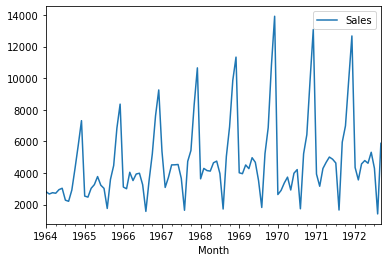

In [15]:
df.plot()

In [16]:
### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [17]:
test_result=adfuller(df['Sales'])

In [18]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [19]:
adfuller_test(df['Sales'])

ADF Test Statistic : -1.8335930563276297
p-value : 0.3639157716602417
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


## Differencing

In [20]:
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)

In [21]:
df['Sales'].shift(1)

Month
1964-01-01       NaN
1964-02-01    2815.0
1964-03-01    2672.0
1964-04-01    2755.0
1964-05-01    2721.0
               ...  
1972-05-01    4788.0
1972-06-01    4618.0
1972-07-01    5312.0
1972-08-01    4298.0
1972-09-01    1413.0
Name: Sales, Length: 105, dtype: float64

In [22]:
df['Seasonal First Difference']=df['Sales']-df['Sales'].shift(12)

In [23]:
df.head(14)

,Sales,Sales First Difference,Seasonal First Difference
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [24]:
## Again test dickey fuller test
adfuller_test(df['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213163
p-value : 2.060579696813685e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot:xlabel='Month'>

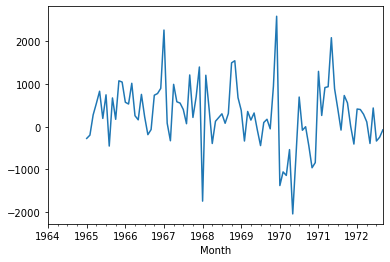

In [25]:
df['Seasonal First Difference'].plot()

## Auto Regressive Model
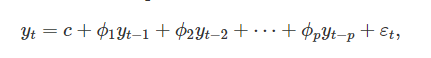

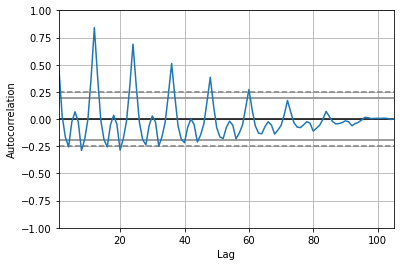

In [26]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])
plt.show()

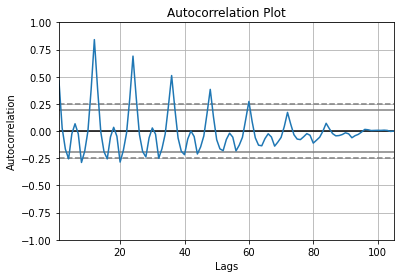

In [27]:
# Plot autocorrelation
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Sales'])
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.show()

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

In [28]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

C:\Users\anand\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


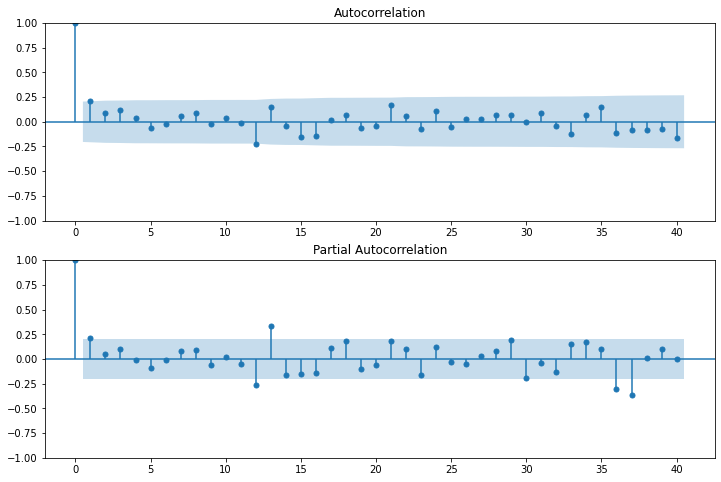

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

In [30]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
# from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [31]:
model=ARIMA(df['Sales'],order=(1,1,1))
model_fit=model.fit()

C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [32]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Tue, 08 Aug 2023   AIC                           1911.627
Time:                        18:54:07   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.314      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Month'>

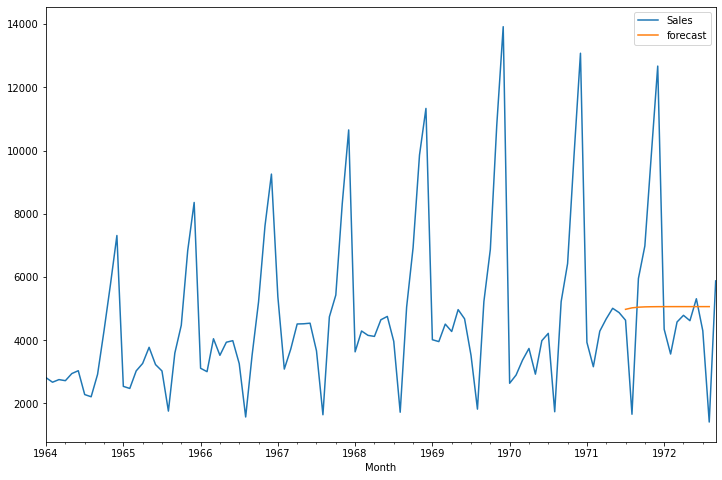

In [33]:
df['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [34]:
import statsmodels.api as sm

In [35]:
model=sm.tsa.statespace.SARIMAX(df['Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<AxesSubplot:xlabel='Month'>

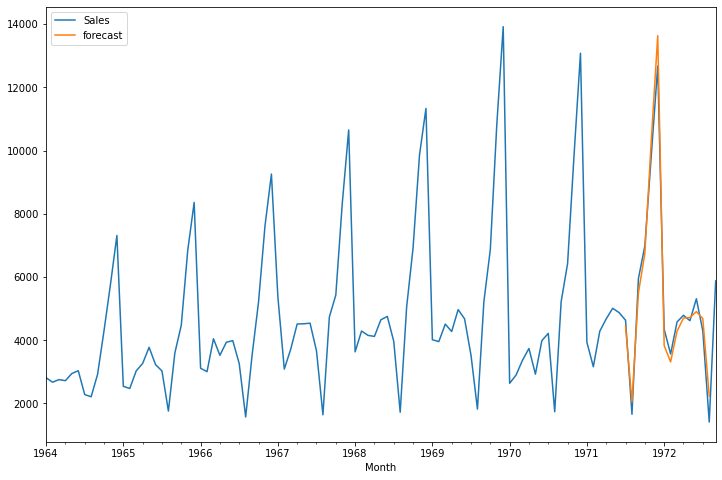

In [36]:
df['forecast']=results.predict(start=90,end=103,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

In [37]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [38]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [39]:
future_datest_df.tail()

,Sales,Sales First Difference,Seasonal First Difference,forecast
1974-04-01,NaN,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN,NaN


In [40]:
future_df=pd.concat([df,future_datest_df])

<AxesSubplot:>

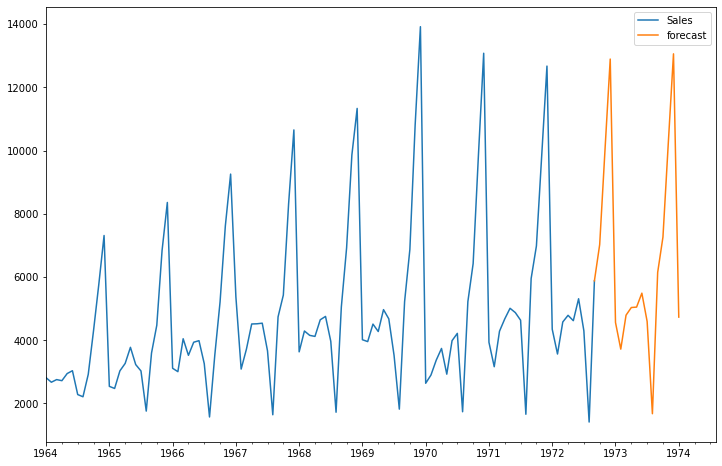

In [41]:
future_df['forecast'] = results.predict(start = 104, end = 120, dynamic= True)  
future_df[['Sales', 'forecast']].plot(figsize=(12, 8)) 

In [42]:

# Perform train-test split
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]['Sales']
test_data = df.iloc[train_size:]['Sales']


In [43]:
# Fit an ARIMA model
# ARIMA(p, d, q) parameters: p = AR order, d = differencing order, q = MA order
p = 1  # AR order
d = 1  # Differencing order
q = 1  # MA order

In [44]:
model_arima = SARIMAX(train_data, order=(p, d, q))
model_arima_fit = model_arima.fit()

C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [45]:
# Forecast using ARIMA model
forecast_arima = model_arima_fit.get_forecast(steps=len(test_data))
forecast_arima_mean = forecast_arima.predicted_mean

In [46]:
# Calculate MAPE for ARIMA
mape_arima = mean_absolute_percentage_error(test_data, forecast_arima_mean)


In [47]:
# Fit Holt's method model
model_holt = ExponentialSmoothing(train_data)
model_holt_fit = model_holt.fit()

C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [48]:
# Forecast using Holt's method model
forecast_holt = model_holt_fit.forecast(steps=len(test_data))

In [49]:
# Calculate MAPE for Holt's method
mape_holt = mean_absolute_percentage_error(test_data, forecast_holt)

In [50]:
# Print MAPE values


In [51]:
# Fit Holt-Winter's method model (Seasonal Exponential Smoothing)
seasonal_periods = 12  # Assuming monthly data and yearly seasonality
model_winter = ExponentialSmoothing(train_data, seasonal='add', seasonal_periods=seasonal_periods)
model_winter_fit = model_winter.fit()


C:\Users\anand\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [52]:
# Forecast using Winter's method model
forecast_winter = model_winter_fit.forecast(steps=len(test_data))


In [53]:
# Calculate MAPE for Winter's method
mape_winter = mean_absolute_percentage_error(test_data, forecast_winter)


In [54]:
# Print MAPE value
print("MAPE for ARIMA:", mape_arima)
print("MAPE for Holt's method:", mape_holt)
print("MAPE for Winter's method:", mape_winter)

MAPE for ARIMA: 0.6700880911146886
MAPE for Holt's method: 2.1757880647074352
MAPE for Winter's method: 0.1989033212285197


In [55]:
# Perform decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Sales'], model='additive', period=12)  # Assuming monthly data with yearly seasonality


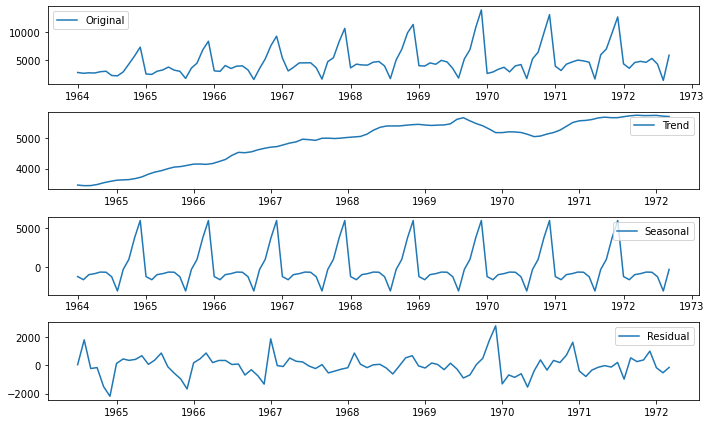

In [56]:
# Plot decomposition components
plt.figure(figsize=(10, 6))
plt.subplot(411)
plt.plot(df['Sales'], label='Original')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()